In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
sns.set(rc={'figure.figsize':(11.7,8.27)})

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [261]:
ratings = pd.read_csv('Data/ramen-ratings.csv')
ratings.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


In [262]:
ratings.shape

(2580, 7)

In [263]:
ratings['Style'].value_counts()

Pack    1531
Bowl     481
Cup      450
Tray     108
Box        6
Can        1
Bar        1
Name: Style, dtype: int64

# Preprocessing

Convert text to lower string and cast stars as a float 

In [264]:
np.unique(ratings['Stars'])

array(['0', '0.1', '0.25', '0.5', '0.75', '0.9', '1', '1.1', '1.25',
       '1.5', '1.75', '1.8', '2', '2.1', '2.125', '2.25', '2.3', '2.5',
       '2.75', '2.8', '2.85', '2.9', '3', '3.0', '3.00', '3.1', '3.125',
       '3.2', '3.25', '3.3', '3.4', '3.5', '3.50', '3.6', '3.65', '3.7',
       '3.75', '3.8', '4', '4.0', '4.00', '4.125', '4.25', '4.3', '4.5',
       '4.50', '4.75', '5', '5.0', '5.00', 'Unrated'], dtype=object)

In [265]:
unrated_idx = ratings[ratings['Stars'] == 'Unrated'].index

ratings = ratings.drop(unrated_idx)

ratings['Brand'] = ratings['Brand'].str.lower() 
ratings['Variety'] = ratings['Variety'].str.lower()
ratings['Stars'] = ratings['Stars'].astype('float')
ratings.head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,new touch,t's restaurant tantanmen,Cup,Japan,3.75,NaN
1,2579,just way,noodles spicy hot sesame spicy hot sesame guan...,Pack,Taiwan,1.00,NaN
2,2578,nissin,cup noodles chicken vegetable,Cup,USA,2.25,NaN
3,2577,wei lih,gge ramen snack tomato flavor,Pack,Taiwan,2.75,NaN
4,2576,ching's secret,singapore curry,Pack,India,3.75,NaN


Derive Tokenized words, bigrams and trigrams from variety

## Exploratory Data Analysis

In [266]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_gram(corpus, ngram, stop_words=None):
    """
    Generates a bag of words as list of tuples for a corpora of words
    :param corpus: list of words to apply bag of words
    :param ngram: int the ngram to be returned
    :param stop_words: list of stop words to remove from bag of words
    :return: Bag of words as a list of tuples sorted in descending order of frequency
    """
    vec = CountVectorizer(stop_words=stop_words, ngram_range=(ngram, ngram)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq


In [267]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
punct_list = list(punctuation)
stop_words += stop_words + punct_list
ramen_common_words = ['noodle', 'noodles', 'ramen', 'instant', 'flavour', 'flavor', 'cup', 'sauce', 'flavouring', 'taste', 'chef', 'authentic', 'version']
ramen_stop_words = stop_words + ramen_common_words  + punct_list

In [268]:
common_n_gram = get_top_n_gram(ratings['Variety'],ngram = 1, stop_words=stop_words)
common_n_gram[:4]

[('noodles', 674), ('noodle', 518), ('instant', 446), ('flavour', 406)]

In [269]:
common_n_gram = get_top_n_gram(ratings['Variety'],ngram = 1, stop_words=ramen_stop_words)
common_n_gram[:4]

[('chicken', 329), ('spicy', 277), ('beef', 233), ('soup', 196)]

In [164]:

def box_plot(df):
    """
    Returns a Seaborn boxplot 
    :param df: Pandas Dataframe
    :return: Seaborn Boxplot
    """
    return sns.boxplot(df['Stars'])

def get_df_words(words, dataframe, column='Variety'):
    """
    This function takes a string of words as an input and generates a df from our input dataframe only
    if the column contains the word
    :param words: A string of words to be matched
    :param dataframe: A pandas DataFrame
    :param column: The column to match words on , defaulted to Variety
    :return: Pandas Dataframe
    """
    assert type(words) is str
    df = dataframe[dataframe[column].str.contains(words, regex=True)]

    return df

def generate_mean_median(dataframe, target_var = 'Stars'):
    """
    Generates the mean and median value of a target variable for a dataframe
    :param dataframe: Pandas DataFrame
    :param target_var: Column Value of Dataframe
    :return: mean, median value
    """
    mean = np.mean(dataframe[target_var])
    median = np.median(dataframe[target_var])

    return mean, median

def generate_stats_df(idx, df, freq, mean, median, word):
    """
    Loops through indicies to create a basic stats dataframe with mean, median, frequency of word
    :param idx: int Index of dataframe
    :param df: Pandas Dataframe
    :param freq: int Frequency of word
    :param mean: float Mean rating of word
    :param median: float Median Rating of word
    :param word: string Bag of Word
    :return: Pandas Dataframe with Word, Frequence, Mean and Median Rating
    """
    df.loc[idx, 'Word'] = word
    df.loc[idx, 'Frequency'] = freq
    df.loc[idx, 'Mean Rating'] = mean
    df.loc[idx, 'Median Rating'] = median
    return df

def n_gram_df(df, ngram, column='Variety', stopwords=ramen_stop_words):
    """
    generates a pandas dataframe with bag of words and additional statistics for ngrams
    :param df: Pandas Dataframe to generate ngram df from
    :param ngram: int, number of grams
    :param column: Target Column that contains text for bag of words
    :param stopwords: list of stopwords, defaulted to ramen_stop_words
    :return: pandas dataframe
    """
    common_n_gram = get_top_n_gram(df[column] ,ngram = ngram, stop_words=stopwords)
    n_gram_df = pd.DataFrame()
    idx = 0
    for word, freq in common_n_gram:
        stats = get_df_words(str(word), ratings)
        mean, median = generate_mean_median(stats)
        generate_stats_df(idx, n_gram_df, freq, mean, median, word)
        idx += 1
    return n_gram_df

def remove_words_from_df(source, target, thresh):
    """
    Drops word from target dataframe that also exist in the source dataframe if the 
    source's frequency percentage in the target is greater than or equal to a threshold 
    :param source: List of source dataframes
    :param target: Pandas DataFrame
    :param thresh: Float value of threshold to 
    :return: Target dataframe with recurring words removed
    """
    words_to_drop = []
    for idx in target.index:
        word = target.loc[idx, 'Word']
        freq = target.loc[idx, 'Frequency']
        for source_df in source:
            source_df_word = source_df[source_df.Word.str.contains(word)]
            for source_idx in source_df_word.index:
                if source_df_word.loc[source_idx, 'Frequency' ] /freq >= thresh:
                    words_to_drop.append(word)
    target = target[~target['Word'].isin(words_to_drop)]
    return target


In [232]:
brand_group = ratings[['Brand','Variety','Stars']].groupby('Brand', as_index = False)\
.agg({'Variety':'size', 'Stars':'median'})
#.sort_values(by=['Variety', 'Stars'],ascending=False).head(20)
    
brand_group.columns = ['Brand', 'Count', 'Median Rating']
more_than_2 = brand_group[brand_group.Count > 2]
more_than_2 = more_than_2.sort_values(by=['Count'],ascending=False).head(15)

one_hit_wonders = brand_group[brand_group.Count <= 2]
one_hit_wonders = one_hit_wonders.sort_values(by=['Median Rating'], ascending=False).head(15)



In [185]:
def count_avg_plot(df, X, Y, title,  Z=None):
    """
    Generates a plot based of an X and Y and an optional Z axis from a pandas dataframe
    :param df: Pandas Dataframe holding X, Y and Z
    :param X: Pandas Series to be plotted on X axis
    :param Y: Pandas Series to be plotted on Y axis
    :param title: String, title of graph
    :param Z: Pandas Series to be plotted on Z axis
    :return: Matplotlib Plot
    """
    ax = df.plot(x=X, y=Y, legend=False, kind='bar', figsize=(15,8), fontsize = 15, title=title, rot = 75)
    ax.grid(False)
    ax.set_ylabel(Y)
    ax.title.set_size(20)
    if Z:
        ax2 = ax.twinx()
        ax2.set_ylabel(Z)
        df.plot(x=X, y=Z, ax=ax2, legend=False, color="r", fontsize=15).grid(False)
    ax.figure.legend(loc=4)
    #ax.xticks(fontsize=14)
    plt.show()

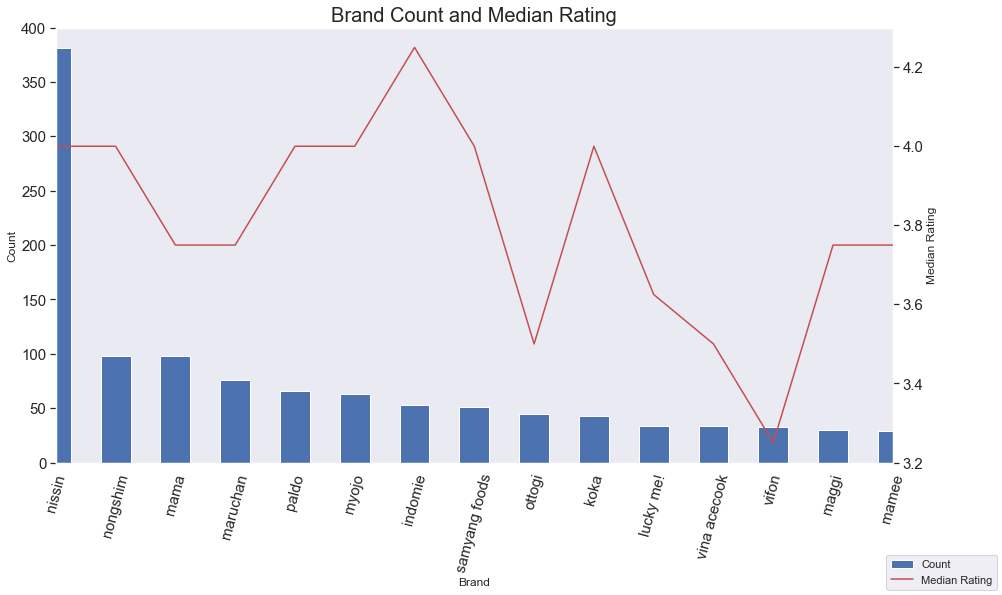

In [233]:
count_avg_plot(more_than_2, "Brand", "Count", "Brand Count and Median Rating","Median Rating")

In [235]:
top_ten = ratings[~ratings['Top Ten'].isnull()]
top_ten_brands = top_ten[['Brand', 'Variety', 'Stars']].groupby('Brand', as_index = False)\
.agg({'Variety':'size', 'Stars':'median'})

top_ten_brands
top_ten_brands.columns = ['Brand', 'Count', 'Median Rating']
top_ten_brands = top_ten_brands.sort_values(by=['Count'], ascending=False).head(15)


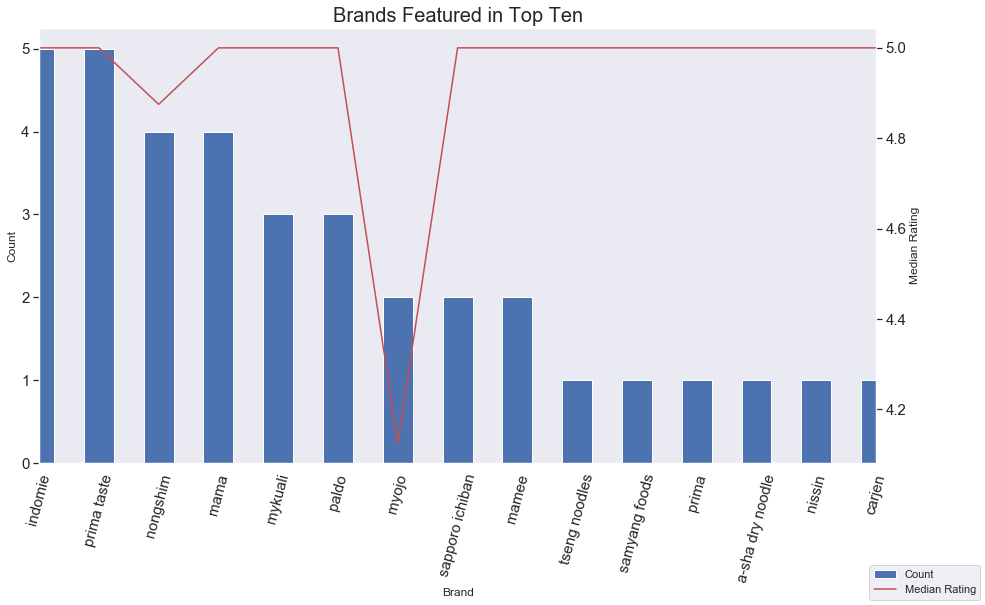

In [237]:
count_avg_plot(top_ten_brands, 'Brand', 'Count', 'Brands Featured in Top Ten','Median Rating')

In [199]:
def generate_concatenated_word_df(df, threshhold=None):
    """
    Generates a unigram, bigram and trigram dataframe.
    Removes common words from the unigram and bigram dataframe based 
    on a threshold and concatenates the three dataframes 
    :param df: Input Pandas Dataframe
    :param threshhold: float threshold 
    :return: Concatenated pandas dataframe
    """
    uni = n_gram_df(df, 1)
    bi = n_gram_df(df, 2)
    tri = n_gram_df(df, 3)
    uni = remove_words_from_df([bi, tri], uni, threshhold)
    bi = remove_words_from_df([tri], bi, threshhold)
    return pd.concat([uni, bi, tri])

In [197]:
thailand = generate_concatenated_word_df(ratings[ratings.Country.isin(['Thailand'])]).sort_values(by=['Frequency'], ascending= False)

thailand.head()

,Word,Frequency,Mean Rating,Median Rating
0,tom,65.0,3.736607,3.75
1,yum,54.0,3.805495,3.75
0,tom yum,54.0,3.822414,3.75
2,shrimp,34.0,3.533333,3.50
3,rice,28.0,3.390411,3.50


In [222]:
countries = np.unique(ratings.Country)
len(countries)
word_country_df = pd.DataFrame()
threshold = 0.4
print('These are the most popular ramen styles/flavours by country!')
i = 0
for country in countries:
    
    try:
        country_df = ratings[ratings.Country.isin([country])]
        top_word_df = generate_concatenated_word_df(country_df, threshold) \
        .sort_values(by=['Frequency'], ascending= False)
        top_word = top_word_df['Word'].head(3).values
        median_rating = top_word_df['Median Rating'].head(1).values
        words_str = ', '.join(word for word in top_word)
        print(country,':', words_str)
        word_country_df.loc[i, 'Country'] = country
        word_country_df.loc[i,'Main Theme'] = top_word[0]
        word_country_df.loc[i, 'Main Theme Rating'] = median_rating
        word_country_df.loc[i,'Top 3 Themes'] = str(words_str)
        i += 1
        #word_country_dict[country] = top_word[0]
    except:
        pass

These are the most popular ramen styles/flavours by country!
Australia : chicken, mi goreng, beef
Bangladesh : oriental style, mr curry, mr beef
Brazil : sabor calabresa, sabor galinha caipira, lamen sabor picanha
Cambodia : shrimp tom yum, minced pork, stewed beef
Canada : chicken, soup, beef
China : beef, artificial, spicy
Colombia : sabor, sabor carne sopa, sopa con fideos
Finland : nuudeli, nuudeli kana nudlar, kana nudlar kyckling
Germany : soba, demae, beef
Ghana : beef light soup
Holland : good, sate, good chicken
Hong Kong : soup, seafood, spicy
Hungary : shrimp, chicken, duck
India : masala, minute, curry
Indonesia : rasa, mi goreng, chicken
Japan : udon, shoyu, tonkotsu
Malaysia : penang white curry, perisa, kari
Mexico : sabor, sopa nissin sabor, sabor pollo
Myanmar : rangers snack, coconut milk, shrimp tom yum
Nepal : chicken, vegetable, rumpum
Netherlands : oriental, island flavours, soup
Pakistan : shoop, pizza, chatt patta
Philippines : chicken, supreme, pancit canton
Po

In [223]:
import pycountry
def generate_iso_alpha_list(dataframe, country_col):
    """
    Appends as 'ISO' column, which contains the alpha3 country code 
    to a pandas dataframe by utilizing the pycountry countries API
    :param dataframe: Pandas Dataframe 
    :param country_col: string Column that contains the country name
    :return: Pandas Dataframe with appended ISO column
    """
    for idx in dataframe.index:
        country = dataframe.loc[idx, country_col]
        try:
            iso = pycountry.countries.get(name=country).alpha_3
            dataframe.loc[idx, 'ISO'] = iso
        except Exception as e:
            try:
                iso = pycountry.countries.get(common_name=country).alpha_3
                dataframe.loc[idx, 'ISO'] = iso
            except Exception as e:
                print(country, e)
                pass
    return dataframe

In [224]:
word_country_df['Country']\
.replace({"USA": "United States", "UK": "United Kingdom", "South Korea":"Korea, Republic of", "Holland": "Netherlands"}, inplace=True)

In [256]:
word_country_df = word_country_df[~word_country_df.ISO.isnull()]

In [271]:
word_country_df

,Country,Main Theme,Main Theme Rating,Top 3 Themes,ISO
0,Australia,chicken,3.500,"chicken, mi goreng, beef",AUS
1,Bangladesh,oriental style,3.250,"oriental style, mr curry, mr beef",BGD
2,Brazil,sabor calabresa,4.250,"sabor calabresa, sabor galinha caipira, lamen ...",BRA
3,Cambodia,shrimp tom yum,4.000,"shrimp tom yum, minced pork, stewed beef",KHM
4,Canada,chicken,3.500,"chicken, soup, beef",CAN
5,China,beef,3.500,"beef, artificial, spicy",CHN
6,Colombia,sabor,4.000,"sabor, sabor carne sopa, sopa con fideos",COL
7,Finland,nuudeli,3.500,"nuudeli, nuudeli kana nudlar, kana nudlar kyck...",FIN
8,Germany,soba,4.000,"soba, demae, beef",DEU
9,Ghana,beef light soup,NaN,beef light soup,GHA


In [257]:

word_country_df = word_country_df.drop([32])

KeyError: '[32] not found in axis'

In [226]:
word_country_df = generate_iso_alpha_list(word_country_df, 'Country')

Sarawak 'NoneType' object has no attribute 'alpha_3'


In [270]:
import plotly.express as px

#df = px.data.gapminder().query("year==2007")
fig = px.choropleth(word_country_df, locations="ISO",
                    color="Main Theme", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    hover_data=["Main Theme Rating", "Top 3 Themes"],
                    color_discrete_sequence=px.colors.qualitative.Light24)

fig.update_layout(
    title_text = 'Popular Ramen themes of the world!',
)
fig.show()

In [272]:
import chart_studio
import os
username = 'kdhawan' # your username
api_key = '4aoJcDQnfpj76EtCTTz1' # your api key - go to profile > settings > regenerate key
chart_studio.tools.set_credentials_file(username=username, api_key=api_key,)

os.environ['REQUESTS_CA_BUNDLE'] = '/Users/kdhawan/Desktop/cacert.pem'

In [273]:
import chart_studio.plotly as py
py.plot(fig, filename = 'ramen_in_world', auto_open=True)

'https://plotly.com/~kdhawan/0/'

In [208]:
threshold = 0.1
all_words = generate_concatenated_word_df(ratings, threshold)
all_words_sorted = all_words.sort_values(by='Median Rating', ascending = False)
all_words_sorted_20 = all_words_sorted.head(20)

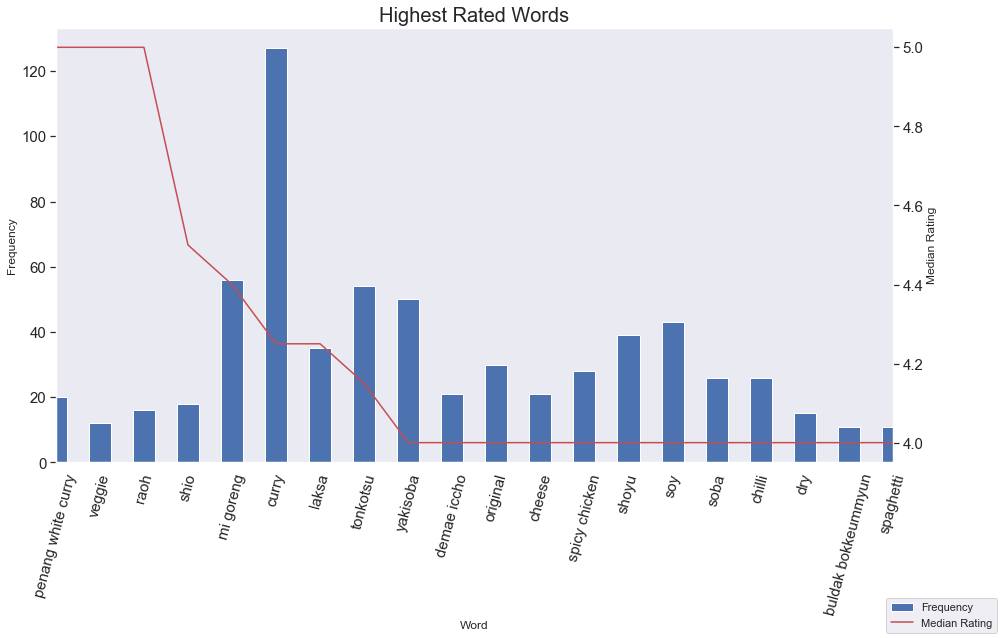

In [132]:
count_avg_plot(all_words_sorted_20, "Word", "Frequency", "Highest Rated Words", "Median Rating")

In [137]:
all_words_sorted.sample(5)

,Word,Frequency,Mean Rating,Median Rating
63,garlic,25.0,3.750000,3.75
40,onion,37.0,3.504054,3.75
87,shio,18.0,4.302632,4.50
52,crab,32.0,3.814516,3.75
0,penang white curry,20.0,4.887500,5.00


In [229]:
all_words[all_words.Frequency > 10].sort_values(by=['Median Rating'], ascending=False).head(20)

,Word,Frequency,Mean Rating,Median Rating
123,singapore,13.0,4.553571,5.000
25,penang,54.0,4.675926,5.000
146,aloe,11.0,4.340909,5.000
0,penang white curry,19.0,4.887500,5.000
55,taste,32.0,4.492188,5.000
132,veggie,12.0,4.187500,5.000
149,jumbo,11.0,4.500000,5.000
103,raoh,16.0,4.781250,5.000
144,sichuan,11.0,3.977273,4.750
115,chef,15.0,4.383333,4.750


In [238]:
get_df_words('mi goreng', ratings).sort_values(by='Stars', ascending = False).head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
142,2438,world o' noodle,mi goreng original flavour fried noodles,Pack,Indonesia,5.0,NaN
977,1603,salam mie,mi goreng ala jawa dengan sambal cabe asli,Pack,Indonesia,5.0,NaN
2533,47,indomie,mi goreng jumbo barbecue chicken,Pack,Indonesia,5.0,2012 #2
2530,50,indomie,mi goreng,Pack,Indonesia,5.0,NaN
2440,140,mama,mi goreng,Pack,Thailand,5.0,NaN


In [25]:
get_df_words('tonkotsu', ratings).sort_values(by='Stars', ascending = False).head()

,Review #,Brand,Variety,Style,Country,Stars,Top Ten,Varity Tokenized,Variety Bigrams,Variety Trigrams
11,2569,yamachan,yokohama tonkotsu shoyu,Pack,USA,5.0,NaN,"[yokohama, tonkotsu, shoyu]","[(yokohama, tonkotsu), (tonkotsu, shoyu)]","[(yokohama, tonkotsu, shoyu)]"
1095,1485,nongshim,spicy tonkotsu noodle soup,Pack,USA,5.0,NaN,"[spicy, tonkotsu, noodle, soup]","[(spicy, tonkotsu), (tonkotsu, noodle), (noodl...","[(spicy, tonkotsu, noodle), (tonkotsu, noodle,..."
525,2055,nissin,tokyo tokunou gyokai tonkotsu,Bowl,Japan,5.0,NaN,"[tokyo, tokunou, gyokai, tonkotsu]","[(tokyo, tokunou), (tokunou, gyokai), (gyokai,...","[(tokyo, tokunou, gyokai), (tokunou, gyokai, t..."
514,2066,marutai,hakata tonkotsu ramen,Pack,Japan,5.0,NaN,"[hakata, tonkotsu, ramen]","[(hakata, tonkotsu), (tonkotsu, ramen)]","[(hakata, tonkotsu, ramen)]"
496,2084,nissin,demae ramen straight noodle kyushu tonkotsu in...,Pack,Hong Kong,5.0,NaN,"[demae, ramen, straight, noodle, kyushu, tonko...","[(demae, ramen), (ramen, straight), (straight,...","[(demae, ramen, straight), (ramen, straight, n..."


In [142]:
get_df_words('penang white curry', ratings).sort_values(by='Stars', ascending = False).head(10)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
28,2552,mykuali,penang white curry rice vermicelli soup,Bowl,Malaysia,5.0,NaN
770,1810,mykuali,penang white curry noodle (new version),Pack,Malaysia,5.0,NaN
1030,1550,ibumie,penang white currymee,Pack,Malaysia,5.0,NaN
966,1614,the bridge,penang white curry noodle,Pack,Malaysia,5.0,NaN
957,1623,mykuali,penang white curry noodle (new improved tatse),Pack,Malaysia,5.0,NaN
928,1652,myori,malaysia penang white curry noodle original,Pack,Malaysia,5.0,NaN
926,1654,myori,malaysia penang white curry noodle super spicy,Pack,Malaysia,5.0,NaN
203,2377,mykuali,penang white curry instant noodle (japan version),Box,Malaysia,5.0,NaN
1493,1087,mykuali,penang white curry noodle,Pack,Malaysia,5.0,2014 #1
744,1836,vit's,taste of malaysia penang white curry fried ins...,Pack,Malaysia,5.0,NaN


In [241]:
udon = get_df_words('udon', ratings).sort_values(by='Stars', ascending = False)
udon[udon.Brand.isin(['nissin'])]

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
165,2415,nissin,kitsune udon donbei (west),Bowl,Japan,5.00,NaN
1941,639,nissin,gozen kitsune udon,Bowl,Japan,5.00,NaN
581,1999,nissin,curry udon,Cup,Japan,5.00,NaN
1002,1578,nissin,gonbuto tempura udon,Bowl,Japan,4.00,NaN
417,2163,nissin,piritto karakuchi tantan udon,Bowl,Japan,4.00,NaN
576,2004,nissin,donbei dashi shoyu yakiudon,Bowl,Japan,3.75,NaN
1339,1241,nissin,donbei kansai soy sauce flavor udon,Pack,Japan,3.75,NaN
1071,1509,nissin,donbei kitsune udon mini,Bowl,Japan,3.50,NaN
1412,1168,nissin,donbei curry udon (west japanese),Bowl,Japan,3.25,NaN
954,1626,nissin,gonbuto kistune udon,Bowl,Japan,2.75,NaN


In [243]:
ramyun = get_df_words('ramyun', ratings).sort_values(by='Stars', ascending = False)
ramyun.head(10)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
47,2533,nongshim,shin ramyun black,Pack,South Korea,5.00,NaN
393,2187,pulmuone,non-fried ramyun noodle (crab flavor),Pack,South Korea,5.00,NaN
1538,1042,nongshim,potato pork ramyun,Pack,China,5.00,NaN
1829,751,nongshim,shin ramyun black onion,Cup,South Korea,5.00,NaN
606,1974,samyang foods,cheese curry ramyun,Pack,South Korea,5.00,NaN
1166,1414,paldo,cheese ramyun (for us market),Pack,South Korea,5.00,NaN
189,2391,ottogi,jin jjambbong spicy seafood ramyun,Pack,South Korea,5.00,NaN
2002,578,nongshim,shin ramyun black,Pack,South Korea,4.75,2012 #7
1903,677,nongshim,shin ramyun shrimp,Pack,China,4.50,NaN
1662,918,nongshim,tempura udon flavor cup ramyun,Cup,South Korea,4.50,NaN
